# **Project: Product Recommendation System**



Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156226 sha256=e4964cfb28b1db203f55fdd3f006088775810a2bdd91740c907020e5cd08eee9
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
import pandas as pd
import numpy as np

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# for matrix factorisation
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# for kfold cross validation
from surprise.model_selection import KFold

#to surpress warning
import warnings
warnings.filterwarnings('ignore')


from collections import defaultdict

from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
df_el = pd.read_csv('/content/drive/MyDrive/MITDSS/ratings_Electronics.csv') #read in dataset
df_el.columns =  ['user_id', 'prod_id', 'rating', 'timestamp'] #add columns to dataframe
df_el.drop(columns = 'timestamp',inplace=True) #drop timestamp
df = df_el.copy() #copy to keep original dataframe clean

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Also, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [5]:
df_el.head() #top 5 rows

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [6]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [7]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [8]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [9]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [10]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [11]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)


- There are 65,290 rows and 3 columns in the data showing that this is a very large dataset.




### **Data types**

In [12]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object


- There are two objects columns for user and product id as these are just strings. There is a float data type for rating.

### **Checking for missing values**

In [13]:
# Check for missing values present and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


- Comparing the number of rows across all columns to the overall number of rows in the data shows that there are no missing rows
- There are 65290 non null rows in all columns

### **Summary Statistics**

In [14]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

- The mean rating is 4.3 while the minimum rating is 1
- More people rated restaurants higher than lower - 25% percentile is 4 showing that there might be some skewness towards higher ratings
- Further visualisations might confirm the above

### **Checking the rating distribution**

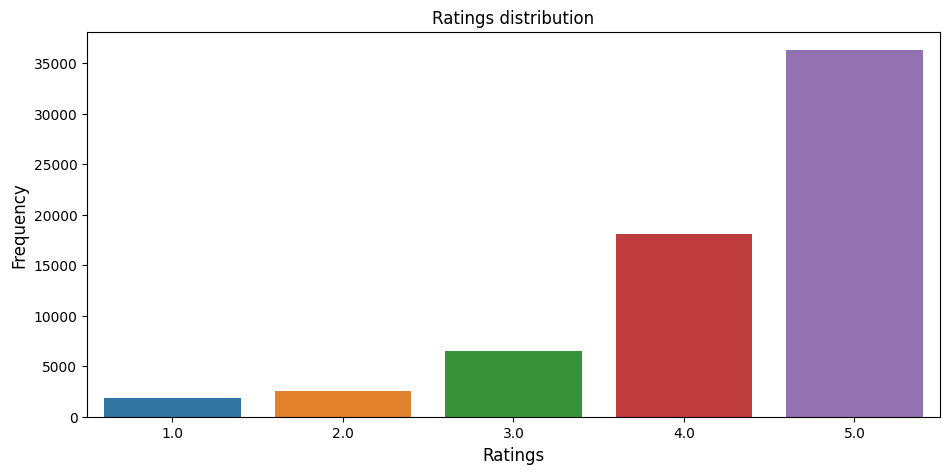

In [15]:
# Create the bar plot and provide observations
plt.figure(figsize = (11, 5))

ax = sns.countplot(x = 'rating', data = df_final) #sns plot of ratings and count by rating

plt.title("Ratings distribution", fontsize = 12) #set title of plot and font size
plt.xlabel("Ratings", fontsize = 12) #set xlabel and font size
plt.ylabel("Frequency", fontsize = 12) #set y label and font size
plt.show() #show plot below


- There are more ratings of 4 and 5 than the lower ratings. 56% rated 5, while 28% rated 4 and combined together this gives 84%. Only 20% rated between 1 and 3
- Few people gave ratings of 1s and 2s to the products which were most likely products that people were not satisfied with.

### **Checking the number of unique users and items in the dataset**

In [16]:
# Number of total rows in the data and number of unique user id and product id in the data
print("The number of total rows in the data is",df_final.shape[0])
print("The number of unique user id is",df_final['user_id'].nunique())
print("The number of unique product id is",df_final['prod_id'].nunique())

The number of total rows in the data is 65290
The number of unique user id is 1540
The number of unique product id is 5689


- There are 1,540 unique user ids and 5,689 unique product ids and there should be possibly 8,761,060 ratings
- There are only 65,290 ratings based on the number of rows meaning not every user has rated a product which makes the data sparse

### **Users with the most number of ratings**

In [17]:
# Top 10 users based on the number of ratings
top_rated = df_final.groupby('user_id')['user_id'].count().sort_values(ascending= False).head(10) #group user id and countin ascending order to get top 10
top_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
Name: user_id, dtype: int64

- The highest number of ratings that a user has given is 295 .
- There are 5689 unique products, 5689-295 leaves about 5934 products that  even this user has not interacted with.
- We would be creating a recommendation system to recommend products to users without prior interaction with that product


**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [18]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id').mean()['rating']

# Calculate the count of ratings for each product
cnt_rating = df_final.groupby('prod_id').count()['rating']
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating':avg_rating,'count_rating':cnt_rating})
# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values(by='average_rating',ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,average_rating,count_rating
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [19]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n(df, n, min_interac):
# Finding products with minimum number of interactions
  recommend = df[df['count_rating']>min_interac]
# Sorting values with respect to average rating
  recommend = recommend.sort_values(by='average_rating',ascending= False)
return recommend.index[:n] #get every index or id up till n


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [20]:
rec_50 = list(top_n(final_rating, 5, 50)) #get list of top 5 product id with at least 50 interactions
rec_50


['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [21]:
rec_100 = list(top_n(final_rating, 5, 100)) #get list of top 5 product id with at least 100 interactions
rec_100


['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [22]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [23]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [24]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0,5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id','prod_id','rating']],reader)

# Splitting the data into train and test datasets
trainset,testset=train_test_split(data,test_size=0.2,random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [25]:
# Declaring the similarity options

sim_options = {'name':'cosine','user_based':True}
# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1

similar_user = KNNBasic(sim_options=sim_options,verbose=False, random_state=1)
# Fit the model on the training data

similar_user.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(similar_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856



- The model has RMSE Of 1.0 showing how much far off the prediction will be from the actual rating
- Precision of 0.855 means that based on the threshold about 85.5% of the recomended products are relevant
- Recall of 0.858 means that based on the threshold about 85.8% of the relevant products have been recommended
- looking at the f1 score, a lot of the relevant products were recommended by the model and a lot the recommended products are relevant


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [26]:
# Predicting rating for a sample user with an interacted product
similar_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

- The actual rating for this product was 5, however the predicted rating was 3.4
- This is not really good as the model in underestimating the actual rating of the product



Below is the **list of users who have not seen the product with product id "1400501466"**.

In [27]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final["prod_id"]!="1400501466"]["user_id"].unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [28]:
# Predicting rating for a sample user with a non interacted product
similar_user.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- The estimated rating for a product that the user has not interacted with is 4.29 which is high

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [29]:
# Setting up parameter grid to tune the hyperparameters
param_grid={'k':[20,30,40],'min_k':[3,6,9],'sim_options':{'name':['msd','cosine'],'user_based':[True]}}
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid,measures=['rmse'],cv=3,n_jobs=-1)
# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9714298114388198
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [30]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options={'name':'cosine',
              'user_based':True}
# Creating an instance of KNNBasic with optimal hyperparameter values
similar_user_opt = KNNBasic(sim_options=sim_options,k=40,min_k=6,verbose=False)
# Training the algorithm on the trainset
similar_user_opt.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similar_user_opt)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87



- The tuning of the hyper parameters reduced the RMSE from 1 in the baseline model to 0.95
- The precision has reduced slightly, the recall has increased in the optimised model and the F1 score has also increased showing that tuning the hyper parameters have contributed to a better model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [31]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similar_user_opt.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [32]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similar_user_opt.predict('A34BZM6S9L7QI4', '1400501466',verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})


- The optimised model now predicts a rating that is close to the actual rating for user id 'A3LDPF5FMB782Z' compared to the baseline model where it was predicting of 3.4
- It predicts the same 4.29 for products that the user has not interacted wth

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [33]:
# 0 is the inner id of the above user
similar_user_opt.get_neighbors(0, k=5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [34]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returning top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [35]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommend = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, similar_user_opt)

In [36]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommend,columns=['prod_id','predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [37]:
# Declaring the similarity options
sim_options={'name':'cosine',
              'user_based':False}
# KNN algorithm is used to find desired similar items. Use random_state=1
similar_item= KNNBasic(sim_options=sim_options,verbose=False,random_state=1)
# Train the algorithm on the trainset, and predict ratings for the test set
similar_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(similar_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- RMSE at 0.99 is better than the baseline model for user-user
- Precision is approx 0.84 showing that 84% of the recommended products are relevant.
- Recall is approx 0.85 showing that 85% of the relevant products have been recommended
- F1 score is high at 84% showing that the recommended products are relevant
- Precision, recall and f1 score are lower compared to the user-user baseline model

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [38]:
# Predicting rating for a sample user with an interacted product
similar_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

- Since RMSE is better, the item-item performs better at predicting a product that has been previously interacted with by the user compared to the user user baseline model

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [39]:
# Predicting rating for a sample user with a non interacted product
similar_item.predict(' A34BZM6S9L7QI4', '1400501466', verbose=True)

user:  A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid=' A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- The item-item baseline perfoms the same as the user-user baseline when predicting products that the user has not interacted with

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [40]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting the data
grid_obj.fit(data)
# Find the best RMSE score
print(grid_obj.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9749811789112689
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [41]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options={'name':'msd',
              'user_based':False}
# Creating an instance of KNNBasic with optimal hyperparameter values
similar_item_opt = KNNBasic(sim_options=sim_options,k=30,min_k=9,verbose=False)
# Training the algorithm on the trainset
similar_item_opt.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE

precision_recall_at_k(similar_item_opt)


RMSE: 0.9567
Precision:  0.838
Recall:  0.889
F_1 score:  0.863


- RMSE has improved from what it was in the baseline model (0.99) . It is still not as good as the RMSE from user-user optimised
- Precision is the same as the baseline item-item model before optimisation
- Recall and F1 score have both improved and increased from what they were before the tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [42]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similar_item_opt.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [43]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similar_item_opt.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- There is a better prediction on products the user has interacted with as this is the closest to the rating that any of the models have predicted.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [44]:
similar_item_opt.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [45]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommend_item=  get_recommendations(df_final,'A1A5KUIIIHFF4U', 5, similar_item_opt)

In [46]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommend_item,columns=['prod_id','predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [47]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


- This rmse is the lowest so far across all the models
- The precision of the baseline svd is lower than the baseline for both user-user and item-item. The recall is however higher than the baseline of user-user baseline model
- The f1 score for this baseline model is slightly higher than the user-user similarity baseline model while it is lower than the optimised user-user similarity model
- Comparing the f1 score to the item-item similarity model. The score is higher than both the baseline and optimised

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [48]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

- The prediction is lower than the actual and when it's compared to user user baseline, this model performs better as it gives a rating that is closer to the actual rating
- The item-item baseline perfoms better in this regard

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [49]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

- The model predicts a higher rating for products that have not been interacted with compared to the baseline user-user model and item-item model

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [50]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_vd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting data
gs_vd.fit(data)
# Best RMSE score
print(gs_vd.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_vd.best_params['rmse'])

0.8984279731916757
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [51]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_opt= SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_algo_optimized=svd_opt.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


- This gives us the lowest and best rmse across all models
- The precision is slightly higher than the baseline svd while the recall is lower
- the f1 score did not change from what it was in the baseline model

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [52]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

In [53]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_algo_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.216280997100113, details={'was_impossible': False})

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**
- Comparing the collaborative filtering models,the item-based baseline performed better than the user-based as it had an RMSE of ~0.99 compared to user based which had a RMSE of 1. Item-based baseline model also gave a prediction that was closer to the actual rating.

- The optimised models of the collaborative models performed better than the baselines. This time the user-based optimized model performed better with a RMSE of 0.9526 and F1 score of 0.87

- Compared to the averaging technique, the collaborative models use a more personalised way to predict. The user-user would use a neighbouring technique to determine similar users to the target user and items they have rated/interacted with.

- Matrix factorization provides a lower RMSE of 0.88 compared to the other models. Tuning the hyperparamaters of the matrix factorisation did not really improve the model by a lot as the f1 score remained the same. The RMSE of the matrix factorization is the lowest of all the models because it accounts for sparsity in the user-item interaction matrix where entries are missing.

- The optimised user-user similarity based recommendation system has performed the best in terms of prediction of items interacted with and not interacted with

- Although the optimised matrix factorisation gave the lowest rmse, the optimised user-user gave a better f1 score of 0.87 which meets the initial goal of ensuring that relevant products are recommended and recommended products are relevant and f1 score of 0.87

- Performing an A/B test with both the user-user and SVD to see how users interact with or buy products suggested using the different models will help in determining the best model